In [1]:
import pandas as pd
import numpy as np
# plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
# for ROC curves 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
# Evaluation 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
# TensorFlow for deep neural neteworks 
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# For Data Augmentation  
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**Check Cuda**

In [2]:
if(tf.test.is_built_with_cuda() == True):
    print("CUDA Available.. Just wait a few moments...")
else: 
    print("CUDA not Available.. May the force be with you.")

CUDA not Available.. May the force be with you.


**Read Dataset**

In [4]:
train = pd.read_csv("train.csv")

In [5]:
X = train.drop(columns=['label'])
y = train['label']

**Normalization**
Normalize image value from range [0 to 255] to [0 to 1]


In [6]:
X = X/255

**Reshape DataSet**

Each image reshape into 28x28x1

In [7]:
X = X.values.reshape(-1,28,28,1)


**Label Encoding**

Use hot encoder vector to encode labels(number to classes)

In [8]:
y = to_categorical(y, num_classes=10) #, num_classes=10

**Split data to 80% train and 20% val**

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Model architecture from paper [link](https://arxiv.org/ftp/arxiv/papers/1909/1909.08490.pdf)
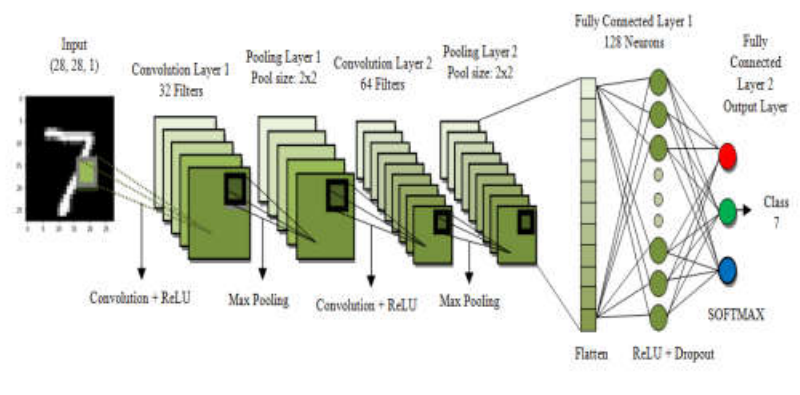

In [10]:
model = Sequential() 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape = (28, 28, 1))) #output (w-f+2p)/s+1  ,padding='valid'
model.add(AveragePooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(AveragePooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 average_pooling2d (Average  (None, 13, 13, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 64)          0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1600)              0

In [11]:
model.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])  #Adam

In [12]:
epochs = 20  #15 
batch_size = 120 #100

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/20
280/280 [==============================] - 6s 20ms/step - loss: 2.2331 - accuracy: 0.2371 - val_loss: 2.0153 - val_accuracy: 0.6188
Epoch 2/20
280/280 [==============================] - 6s 21ms/step - loss: 1.4255 - accuracy: 0.5614 - val_loss: 0.6611 - val_accuracy: 0.8390
Epoch 3/20
280/280 [==============================] - 7s 24ms/step - loss: 0.8116 - accuracy: 0.7387 - val_loss: 0.4542 - val_accuracy: 0.8794
Epoch 4/20
280/280 [==============================] - 7s 26ms/step - loss: 0.6495 - accuracy: 0.7960 - val_loss: 0.3890 - val_accuracy: 0.8925
Epoch 5/20
280/280 [==============================] - 6s 23ms/step - loss: 0.5675 - accuracy: 0.8228 - val_loss: 0.3519 - val_accuracy: 0.8985
Epoch 6/20
280/280 [==============================] - 6s 22ms/step - loss: 0.5021 - accuracy: 0.8464 - val_loss: 0.3132 - val_accuracy: 0.9090
Epoch 7/20
280/280 [==============================] - 6s 21ms/step - loss: 0.4551 - accuracy: 0.8601 - val_loss: 0.2837 - val_accuracy: 0.9192

**Model evaluation**

In [14]:
_, acc = model.evaluate(X_val, y_val, verbose=0)
print('> %.3f' % (acc * 100.0))

> 95.476


**Model prediction for evaluation dataset**

In [15]:
Y_pred = model.predict(X_val)
#print(y_val)
#accuracy = accuracy_score(y_val, y_pred)
#print(f'Accuracy: {accuracy}')
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
print('confusion_mtx ',confusion_mtx)

263/263 [==============================] - 1s 3ms/step
confusion_mtx  [[802   0   1   0   2   3   6   0   1   1]
 [  0 899   4   1   1   0   1   2   1   0]
 [  3   7 804   2   9   1   5   8   6   1]
 [  0   3   8 875   0  17   1  10  15   8]
 [  1   0   5   0 786   1  10   3   0  33]
 [  1   2   0  13   1 671   7   1   2   4]
 [  5   1   1   0   1   3 770   0   4   0]
 [  0   2  12   1   4   1   0 846   3  24]
 [  1   5   5  12   3   8   6   2 785   8]
 [  4   4   1  14   9   5   0  15   4 782]]


**Model Prediction for test data**

In [17]:
X_test = pd.read_csv("test.csv")
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X_test = X_test/255
X_test = X_test.values.reshape(-1,28,28,1)


In [19]:
print(len(X_test))

28000


In [20]:

# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
print(results[0:5])

875/875 [==============================] - 3s 3ms/step
0    2
1    0
2    9
3    9
4    3
Name: Label, dtype: int64


In [21]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1) 

submission.to_csv("sample_submission.csv",index=False)